In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys
import os

In [324]:
# results = pd.read_csv("../test_results/hyper_sdqlpy_dense_tuning_test_results.csv") 
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_direct_optimisations_test_results.csv") 

In [325]:
print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

Overall Results: 176
Correct Results: 176


In [326]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        if isinstance(name, int):
            return name
        else:
            return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])
    
    def ignore_first_mean(runs):
        return sum(runs[1:]) / len(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

results = pre_process(results)

In [327]:
def make_overall_table(df):
    overall = df.groupby("Query Type").agg(
        overall_mean_runtime=("Mean", g_mean)
    )
    overall = overall.sort_values(by="overall_mean_runtime")
    overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})
    return overall

In [328]:
overall = make_overall_table(results)
overall.head(15)

,Overall Mean Runtime (s)
Query Type,
Hyper DB,0.153907
O1 SDQLpy,0.155856
O4 SDQLpy,0.220752
O2 SDQLpy,0.274375
O3 SDQLpy,0.274924
Naive SDQLpy,0.278308
Pandas Converted + O4 (Hyper DB),0.426387
Pandas Converted (Hyper DB),0.427010


In [333]:
def get_querytype_mean_dict(query_type):
    query_numbers = list(results[results['Query Type'] == query_type].to_dict()['Query Number'].values())
    query_means = list(results[results['Query Type'] == query_type].to_dict()['Mean'].values())

    return dict(zip(query_numbers, query_means))

def percentage_difference(num1, num2):
    return 100 * (abs(num1 - num2) / ((num1 + num2) / 2))

def runtime_reduction(old, new):
    return ((old - new) / old) * 100

all_type = "Pandas Converted + O4 (Hyper DB)"
prev_type = "Pandas Converted (Hyper DB)"

all_runtimes = get_querytype_mean_dict(all_type)
prev_runtimes = get_querytype_mean_dict(prev_type)

slower = 0
faster = 0

threshold = 1
for query, all_runtime in all_runtimes.items():
    prev_runtime = prev_runtimes[query]
    perc_diff = round(percentage_difference(all_runtime, prev_runtime), 5)
    if prev_runtime < all_runtime and perc_diff >= threshold:
        print(f"For Query {query}, '{all_type}' was more than {threshold}% slower than '{prev_type}'.")
        print(f"\t'{all_type}': {all_runtime}")
        print(f"\t'{prev_type}': {prev_runtime}")
        print(f"\tPercentage difference: {perc_diff}%")
        slower += 1
    elif prev_runtime > all_runtime and perc_diff >= threshold:
        print(f"For Query {query}, '{all_type}' was more than {threshold}% faster than '{prev_type}'.")
        print(f"\t'{all_type}': {all_runtime}")
        print(f"\t'{prev_type}': {prev_runtime}")
        print(f"\tPercentage difference: {perc_diff}%")
        faster += 1
        
print(f"{slower} Queries were Slower after Optimising")
print(f"{faster} Queries were Faster after Optimising")

# round(percentage_difference(0.274375, 0.278308), 5)

For Query 1, 'Pandas Converted + O4 (Hyper DB)' was more than 1% slower than 'Pandas Converted (Hyper DB)'.
	'Pandas Converted + O4 (Hyper DB)': 1.4207793712615966
	'Pandas Converted (Hyper DB)': 1.3946865558624268
	Percentage difference: 1.85353%
For Query 2, 'Pandas Converted + O4 (Hyper DB)' was more than 1% faster than 'Pandas Converted (Hyper DB)'.
	'Pandas Converted + O4 (Hyper DB)': 0.3020501136779785
	'Pandas Converted (Hyper DB)': 0.30668911933898924
	Percentage difference: 1.52414%
For Query 4, 'Pandas Converted + O4 (Hyper DB)' was more than 1% slower than 'Pandas Converted (Hyper DB)'.
	'Pandas Converted + O4 (Hyper DB)': 0.21816549301147461
	'Pandas Converted (Hyper DB)': 0.19515514373779297
	Percentage difference: 11.13438%
For Query 5, 'Pandas Converted + O4 (Hyper DB)' was more than 1% faster than 'Pandas Converted (Hyper DB)'.
	'Pandas Converted + O4 (Hyper DB)': 0.37703328132629393
	'Pandas Converted (Hyper DB)': 0.38100223541259765
	Percentage difference: 1.04717%
Fo

In [ ]:
def runtime_reduction(old, new):
    return ((old - new) / old) * 100

runtime_reduction(0.08513712882995605, 0.07212376594543457)

15.285179408050048

In [ ]:
runtime_reduction(0.427010, 0.426387)

0.1458982225240591

In [ ]:
# IQR
naive_results = results[results["Query Type"] == 'Naive SDQLpy']
Q1 = naive_results['Mean'].quantile(0.25)
Q3 = naive_results['Mean'].quantile(0.75)
print(f"Naive IQR: {Q3 - Q1}")

o4_results = results[results["Query Type"] == 'O4 SDQLpy']
Q1 = o4_results['Mean'].quantile(0.25)
Q3 = o4_results['Mean'].quantile(0.75)
print(f"O4 IQR: {Q3 - Q1}")

Naive IQR: 0.6796446800231933
O4 IQR: 0.4523171782493591


## Boxplots

In [ ]:
results['Query Type'] = results['Query Type'].replace(
    {
        'Pandas Converted (Hyper DB)': 'Pandas',
        'Pandas Converted + O4 (Hyper DB)': 'O4 Pandas'
    }
)

In [ ]:
results

,Query Type,Query Number,Mean,Runs
0,Hyper DB,1,0.129322,"[0.13045930862426758, 0.1293809413909912, 0.12..."
1,Naive SDQLpy,1,1.295751,"[1.366431713104248, 1.3349874019622803, 1.2851..."
2,O1 SDQLpy,1,0.073416,"[0.07568359375, 0.07184267044067383, 0.0736100..."
3,O2 SDQLpy,1,1.343711,"[1.3827297687530518, 1.3863816261291504, 1.312..."
4,O3 SDQLpy,1,1.333620,"[1.4018220901489258, 1.3590068817138672, 1.331..."
...,...,...,...,...
170,O1 SDQLpy,22,0.027338,"[0.03550386428833008, 0.02771592140197754, 0.0..."
171,O2 SDQLpy,22,0.028643,"[0.039954423904418945, 0.028383493423461914, 0..."
172,O3 SDQLpy,22,0.061738,"[0.07193589210510254, 0.0604250431060791, 0.06..."
173,O4 SDQLpy,22,0.029004,"[0.03833436965942383, 0.02956557273864746, 0.0..."


In [ ]:
# Compare 
compare_groups = [
    ("O4_graph.pdf", ["Naive SDQLpy", "O4 SDQLpy", "Pandas", "O4 Pandas"]),
    ("O1_graph.pdf", ["Naive SDQLpy", "O1 SDQLpy"]),
    ("O2_graph.pdf", ["Naive SDQLpy", "O2 SDQLpy"]),
    ("O3_graph.pdf", ["Naive SDQLpy", "O3 SDQLpy"])
]

In [ ]:
def make_boxplot_graph(original_df, data_labels, filename = None):
    new_df = original_df[original_df["Query Type"].isin(data_labels)]
    # Convert to ms
    new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
    
    new_df['Query Type'] = new_df['Query Type'].replace(
        {
            'O4 SDQLpy': 'Variable Elimination\nSDQLpy', 
            'O4 Pandas': 'Variable Elimination\nPandas', 
            'O1 SDQLpy': 'Fusion\nSDQLpy', 
            'O2 SDQLpy': 'Update Sum\nSDQLpy', 
            'O3 SDQLpy': 'Dense\nSDQLpy', 
        }
    )

    with sns.axes_style("ticks"):
        sns.set_theme(rc={'figure.figsize':(8,6)})

        ax = sns.boxplot(data=new_df, x="Query Type", y="Mean", color="#D9D9D9", linecolor="#137", linewidth=.75)
        
        ax.set_ylabel("Runtime (ms)")
        ax.set_xlabel("")
        
        # Make axes weightier
        plt.setp(ax.spines.values(), linewidth=1)
        
        for spine in ax.spines.values():
            spine.set_edgecolor('k')
            
        ax.spines[['right', 'top']].set_visible(False)
        
        plt.tight_layout()
    
        if filename != None:
            os.makedirs(os.path.dirname(filename), exist_ok=True)  
            plt.savefig(filename, bbox_inches="tight", transparent=True)
        
        plt.show()

/tmp/ipykernel_88726/3796061260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_88726/3796061260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


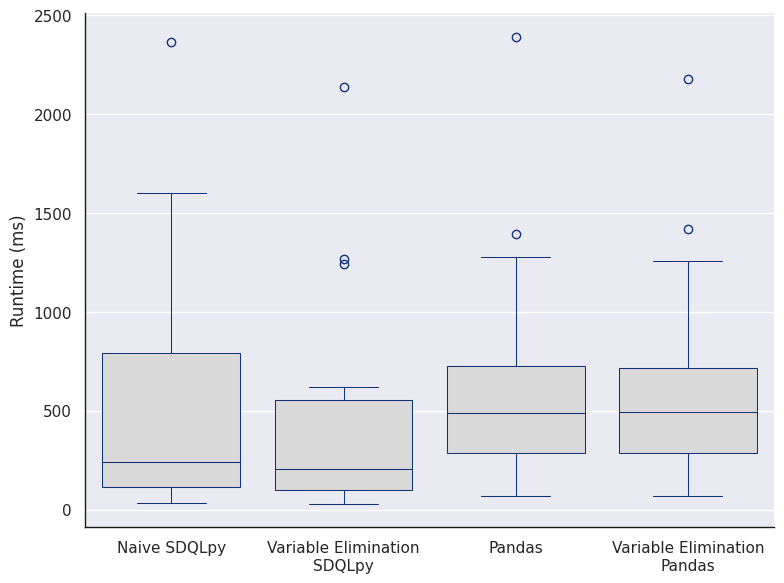

/tmp/ipykernel_88726/3796061260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_88726/3796061260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


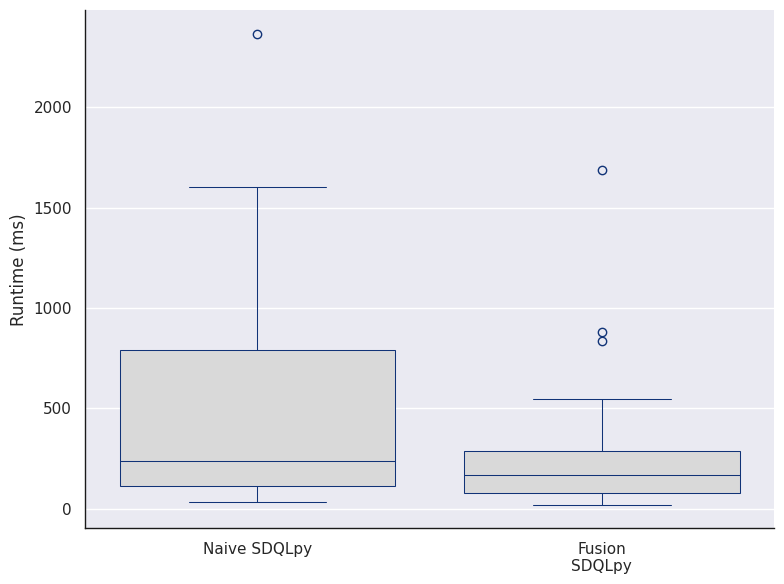

/tmp/ipykernel_88726/3796061260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_88726/3796061260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


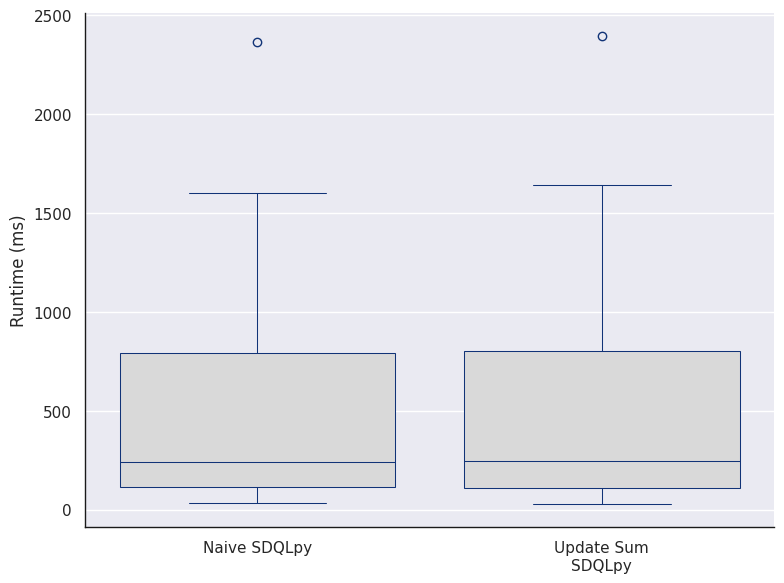

/tmp/ipykernel_88726/3796061260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_88726/3796061260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


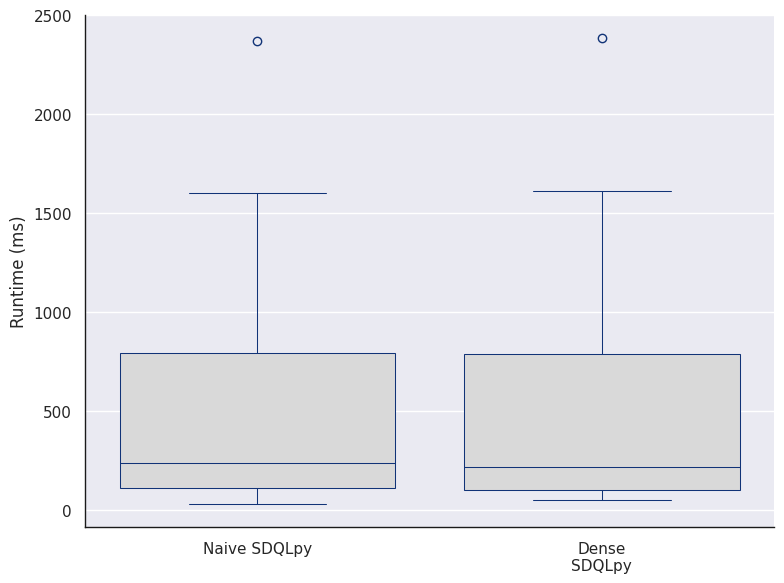

In [ ]:
for filename, data_labels in compare_groups:
    make_boxplot_graph(
        results,
        data_labels,
        f"../analysis_results/y2_report/{filename}"
    )

## Dense Hyper Parameter Tuning

In [ ]:
results = pd.read_csv("../test_results/hyper_sdqlpy_dense_tuning_test_results.csv") 

print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

results = pre_process(results)

Overall Results: 286
Correct Results: 286


In [ ]:
# O1 SDQLpy	: 0.155856

dense_overall = make_overall_table(results)
dense_overall.head(15)

,Overall Mean Runtime (s)
Query Type,
O3 (0.4) SDQLpy,0.142164
O3 (0.5) SDQLpy,0.142544
O3 (0.9999) SDQLpy,0.142696
O3 (0.6) SDQLpy,0.142729
O3 (0.3) SDQLpy,0.142804
O3 (0.7) SDQLpy,0.143092
O3 (0.9) SDQLpy,0.144155
O3 (0.8) SDQLpy,0.144403
O3 (0.2) SDQLpy,0.144925


In [ ]:
naive_runtime = 0.155856

In [ ]:
new_den = dense_overall.reset_index()
new_den = new_den[new_den["Query Type"].str.contains("SDQLpy")]
dense_numbers = list(new_den["Overall Mean Runtime (s)"])
print(min(dense_numbers))
print(f"Best O3: {runtime_reduction(naive_runtime, min(dense_numbers))}")
print(f"Worst O3: {runtime_reduction(naive_runtime, max(dense_numbers))}")

0.14216411992018402
Best O3: 8.784955394605262
Worst O3: -5.908025623569633


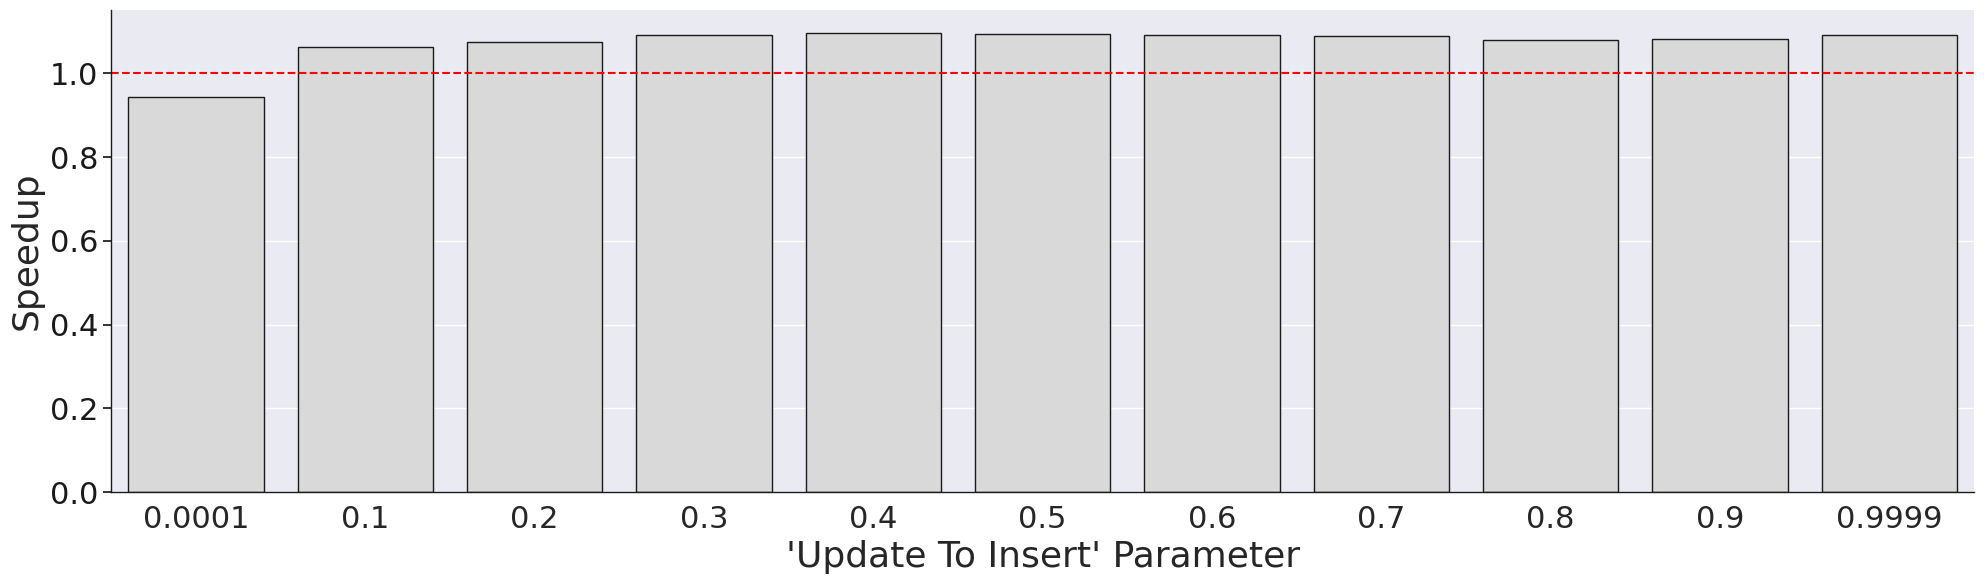

In [ ]:
sns.set_theme(rc={'figure.figsize':(20,6)})

plt.rcParams['patch.linewidth'] = 1.0
plt.rcParams['patch.edgecolor'] = 'k'

# Filter results for SDQLpy
filter_dense = dense_overall.reset_index()
filter_dense = filter_dense[filter_dense["Query Type"].str.contains("SDQLpy")]
filter_dense['Overall Mean Runtime (s)'] = filter_dense['Overall Mean Runtime (s)'].apply(lambda x : naive_runtime / x)
filter_dense['Query Type'] = filter_dense['Query Type'].replace(
    {
        "O3 (0.4) SDQLpy": "0.4",
        "O3 (0.5) SDQLpy": "0.5",
        "O3 (0.9999) SDQLpy": "0.9999",
        "O3 (0.0001) SDQLpy": "0.0001",
        "O3 (0.6) SDQLpy": "0.6",
        "O3 (0.3) SDQLpy": "0.3",
        "O3 (0.7) SDQLpy": "0.7",
        "O3 (0.9) SDQLpy": "0.9",
        "O3 (0.8) SDQLpy": "0.8",
        "O3 (0.2) SDQLpy": "0.2",
        "O3 (0.1) SDQLpy": "0.1"
     }
)


# Set order
ax = sns.barplot(data=filter_dense, x="Query Type", y="Overall Mean Runtime (s)", color="#D9D9D9",
                 order=sorted([float(x) for x in list(filter_dense["Query Type"])]))

ax.set_ylabel("Speedup", fontsize=26)
ax.set_xlabel("'Update To Insert' Parameter", fontsize=26)

# Make axes weightier
plt.setp(ax.spines.values(), linewidth=1)

for spine in ax.spines.values():
    spine.set_edgecolor('k')
    

ax.tick_params(axis='x', which='major', labelsize=22)
ax.tick_params(axis='y', which='major', direction="out", colors="k", left=True, labelsize=22)

ax.spines[['right', 'top']].set_visible(False)

ax.axhline(y = 1.0, xmin = 0, xmax = 1,
           color = "red", linestyle = "dashed")

plt.tight_layout()

filename = f"../analysis_results/y2_report/dense_tuning.pdf"
if filename != None:
    os.makedirs(os.path.dirname(filename), exist_ok=True)  
    plt.savefig(filename, bbox_inches="tight", transparent=True)

plt.show()

### TPC-H Selectivity Histogram

In [ ]:
selectivity_data = pd.read_csv("../../tpch_cardinality_tracking.csv")

In [ ]:
min(list(selectivity_data["Cardinalities"]))

0.001

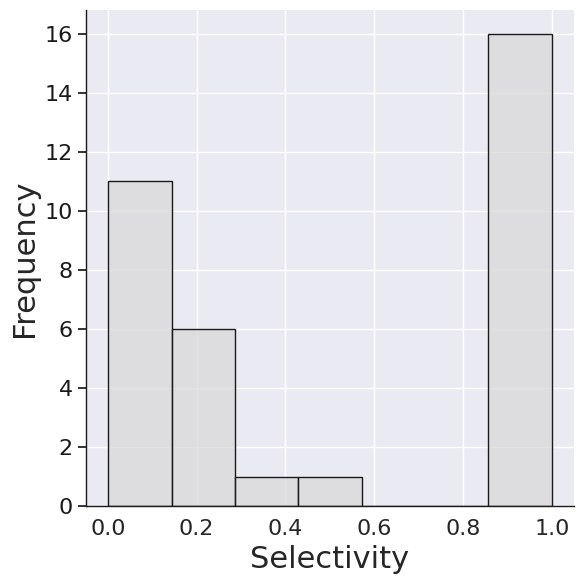

In [ ]:
sns.set_theme(rc={'figure.figsize':(6,6)})

plt.rcParams['patch.linewidth'] = 1.0
plt.rcParams['patch.edgecolor'] = 'k'

# Set order
ax = sns.histplot(data=selectivity_data, x="Cardinalities", color="#D9D9D9")

ax.set_ylabel("Frequency", fontsize=22)
ax.set_xlabel("Selectivity", fontsize=22)

# Make axes weightier
plt.setp(ax.spines.values(), linewidth=1)

for spine in ax.spines.values():
    spine.set_edgecolor('k')
    

ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', direction="out", colors="k", left=True, labelsize=16)

ax.spines[['right', 'top']].set_visible(False)


plt.tight_layout()

filename = f"../analysis_results/y2_report/tpch_selectivies.pdf"
if filename != None:
    os.makedirs(os.path.dirname(filename), exist_ok=True)  
    plt.savefig(filename, bbox_inches="tight", transparent=True)

plt.show()